# Ensamble-based Models:
- Combining Models

__Part 2__
 > - Boosting
 > - Stacking

In [7]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt, os
import pickle
%matplotlib inline
working_directory = os.getcwd()

In [8]:
# import the encoded covid df
encoded_df = pd.read_csv(working_directory + '/VAERSData/encoded_df.csv')

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
y, X = encoded_df['RECOVD'], encoded_df.drop(columns='RECOVD')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)

## Gradient Boosting
> - Fit gradient boosted tree with `max_features`set to 5 and all other parameters set to default
> - Evaluate the accuracy on test data for each of these models
> - Plot the accuracy as a function of estimator number

*Note** Boosting Models tend to take more run time than Bagging Models as they fit trees successively

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [5]:
error_list = list()

# iterate through various possibilities of the number of trees
tree_list = [50, 100, 300, 500, 1000, 2000, 5000, 10000, 20000, 40000]
for n_trees in tree_list:
    GBC = GradientBoostingClassifier(max_features=5, n_estimators=n_trees, random_state=42)
    
    # Fit the model
    print(f'Fitting model with{n_trees} trees')
    GBC.fit(X_train.values, y_train.values)
    y_pred = GBC.predict(X_test)
    
    # Get the error
    error = 1.0 - accuracy_score(y_test, y_pred)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))
    
error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')    
error_df    

Fitting model with50 trees
Fitting model with100 trees
Fitting model with300 trees
Fitting model with500 trees
Fitting model with1000 trees
Fitting model with2000 trees
Fitting model with5000 trees
Fitting model with10000 trees
Fitting model with20000 trees
Fitting model with40000 trees


,error
n_trees,
50.0,0.406998
100.0,0.402676
300.0,0.398721
500.0,0.398927
1000.0,0.398159
2000.0,0.397918
5000.0,0.397505
10000.0,0.397505
20000.0,0.397414


In [6]:

pickle.dump(error_df, open('error_df.p', 'wb')) 

In [6]:
error_df = pickle.load(open('error_df.p', 'rb'))

(0.0, 44000.0)

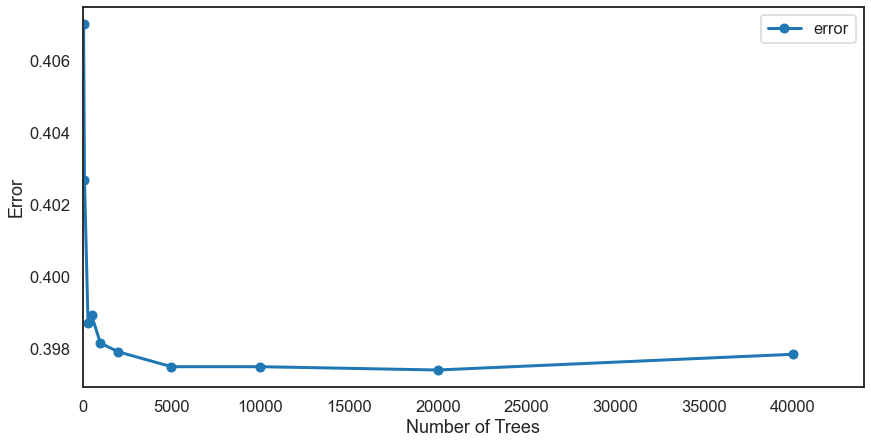

In [10]:
sns.set_context('talk')
sns.set_style('white')

# Create the plot
ax = error_df.plot(marker='o', figsize=(14,7), linewidth=3)

# Set parameter
ax.set(xlabel='Number of Trees', ylabel='Error')
ax.set_xlim(0, max(error_df.index)*1.1)

## GridSearchCV

> - Using a grid search with cross-validation, fit a new gradient boosted classifier with the number of trees equal to 10000.
> - Vary the learning rates (0.1, 0.01, 0.001, etc), 
the subsampling value (1.0 or 0.5), number of maximum features(1, 2, etc)
> - Examin the parameters of the best fit model.
> - Calculate relevant error metrics on this model and examin the confusion matrix.


In [12]:
from sklearn.model_selection import GridSearchCV

# Note: Running hours here took more than 3 hours
# The parameters to be fit
param_grid = {'learning_rate': [0.1, 0.01, 0.001],
               'subsample': [1.0, 0.5],
               'max_features': [2, 3]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(n_estimators= 20000, random_state=42),
                 param_grid= param_grid,
                 scoring='accuracy',
                 n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

In [13]:
# store the grid search df
import pickle
pickle.dump(GV_GBC, open('gv_gbc.p', 'wb')) 

In [14]:
# to read the file again: 
GV_GBC = pickle.load(open('gv_gbc.p', 'rb'))

In [15]:
# The best model
GV_GBC.best_estimator_

GradientBoostingClassifier(learning_rate=0.01, max_features=3,
                           n_estimators=20000, random_state=42, subsample=0.5)

In [16]:
from sklearn.metrics import classification_report

y_pred = GV_GBC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.66      0.60      0.63     73111
           1       0.54      0.60      0.57     57724

    accuracy                           0.60    130835
   macro avg       0.60      0.60      0.60    130835
weighted avg       0.61      0.60      0.60    130835



In [26]:
param_grid = {'learning_rate': [0.1, 0.01, 0.001],
               'subsample': [1.0, 0.5],
               'max_features': [4, 5]}

# The grid search object
GV_GBC2 = GridSearchCV(GradientBoostingClassifier(n_estimators= 20000, random_state=42),
                 param_grid= param_grid,
                 scoring='accuracy',
                 n_jobs=-1)

# Do the grid search
GV_GBC2 = GV_GBC2.fit(X_train, y_train)

In [27]:
# The best model
GV_GBC2.best_estimator_

GradientBoostingClassifier(learning_rate=0.01, max_features=4,
                           n_estimators=20000, random_state=42, subsample=0.5)

In [28]:
y_pred = GV_GBC2.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.66      0.60      0.63     73005
           1       0.55      0.60      0.57     57830

    accuracy                           0.60    130835
   macro avg       0.60      0.60      0.60    130835
weighted avg       0.61      0.60      0.60    130835



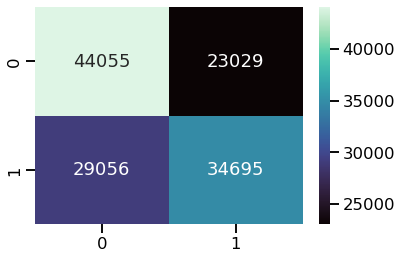

In [17]:
from sklearn.metrics import confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='mako')


In [20]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ABC = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

params_grid = {'learning_rate': [0.1, 0.01, 0.001],
               'n_estimators': [10000, 20000]}

GV_ABC = GridSearchCV(ABC,
                     param_grid= params_grid,
                     scoring= 'accuracy',
                     n_jobs=-1)

GV_ABC = GV_ABC.fit(X_train, y_train)

In [22]:
pickle.dump(GV_ABC, open('gv_abc.p', 'wb')) 

In [23]:
# to read the file again: 
GV_ABC = pickle.load(open('gv_abc.p', 'rb'))

In [24]:
GV_ABC.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.001, n_estimators=20000)

In [25]:
y_pred = GV_ABC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.67      0.58      0.63     77249
           1       0.50      0.59      0.54     53586

    accuracy                           0.59    130835
   macro avg       0.58      0.59      0.58    130835
weighted avg       0.60      0.59      0.59    130835

